<a href="https://colab.research.google.com/github/amarabuco/deeplearning-2024.2/blob/main/Aula_3_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação imagens

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,  transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

In [4]:
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform,
                                       download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

In [5]:
trainset.data[0].shape

torch.Size([28, 28])

In [6]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

8 - eight  7 - seven  7 - seven  4 - four


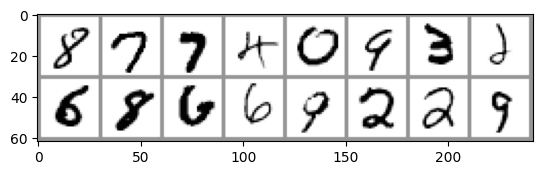

In [10]:
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(trainset.classes[labels[j]] for j in range(4)))

##  MLP

In [11]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 1024)
    self.fc3 = nn.Linear(1024, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.softmax(self.fc3(x))
    return x

In [12]:
mlp = MLP()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

In [16]:
mlp.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)

In [17]:
loss_list = []
stop = 0
for epoch in range(3):
  running_loss = 0.0
  # if stop == 1:
  #   break

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = mlp(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      loss_list.append(running_loss / 2000)
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

      # if (len(loss_list) > 2) and (loss_list[-1] > loss_list[-2]):
      #   stop = 1
      #   break


print('Finished Training')

<ipython-input-11-4d81d8b1e14c>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


[1,  2000] loss: 2.115
[2,  2000] loss: 1.657
[3,  2000] loss: 1.631
Finished Training


In [18]:
correct = 0
total = 0

with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = mlp(images) # calculate outputs by running images through the network

        _, predicted = torch.max(outputs.data, 1) # the class with the highest energy is what we choose as prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

<ipython-input-11-4d81d8b1e14c>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Accuracy of the network on the test images: 85 %


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in trainset.classes}
total_pred = {classname: 0 for classname in trainset.classes}


with torch.no_grad(): # again no gradients needed
    for data in testloader:

        images, labels = data[0].to(device), data[1].to(device)
        outputs = mlp(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[trainset.classes[label]] += 1
            total_pred[trainset.classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

<ipython-input-11-4d81d8b1e14c>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Accuracy for class: 0 - zero is 98.5 %
Accuracy for class: 1 - one is 97.9 %
Accuracy for class: 2 - two is 90.9 %
Accuracy for class: 3 - three is 92.7 %
Accuracy for class: 4 - four is 92.7 %
Accuracy for class: 5 - five is 0.0 %
Accuracy for class: 6 - six is 95.9 %
Accuracy for class: 7 - seven is 92.8 %
Accuracy for class: 8 - eight is 88.1 %
Accuracy for class: 9 - nine is 90.9 %


### Lenet

https://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

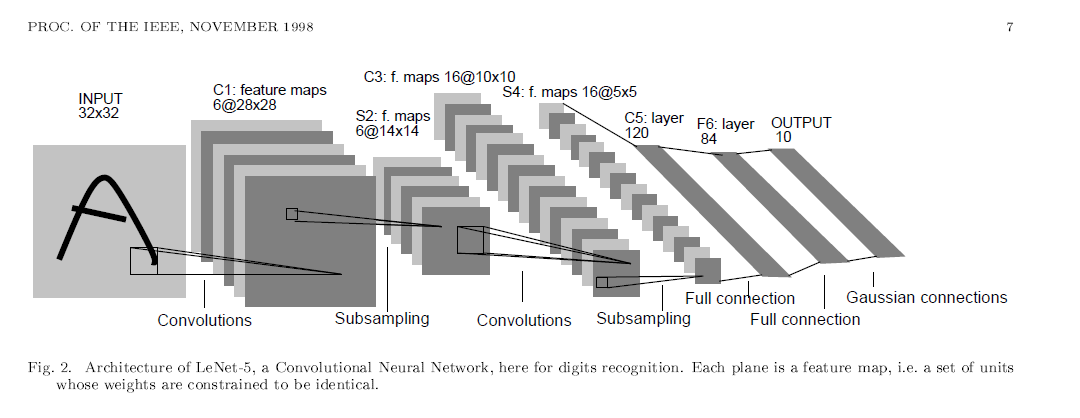

In [20]:
class Lenet(nn.Module):
  def __init__(self):
    super(Lenet, self).__init__()
    #1 input image channel (black & white), 6 outputs channels, 3x3 square convolution kernel
    self.conv1 = torch.nn.Conv2d(1,6,5, padding=2)
    self.conv2 = torch.nn.Conv2d(6,16,3)
    # an affine operation: y = Wx + b
    self.fc1 = torch.nn.Linear(16*6*6, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # If the size is a square you can only specify a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

lenet = Lenet()
lenet.to(device)

Lenet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# class MyLenet(nn.Module):
#   def __init__(self):
#     super(Lenet, self).__init__()
#     self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0, padding_mode='zeros', dilation=1, groups=1, bias=True)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, padding_mode='zeros', dilation=1, groups=1, bias=True)
#     self.fc1 = nn.Linear(120,84)
#     self.fc2 = nn.Linear(84,10)

#   def forward(self, x):
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     x = x.view(x.size(0), -1)  # Dynamically calculate the flattened size
#     x = F.relu(self.fc1(x))
#     x = self.fc2(x)
#     return x

# lenet = Lenet()

In [22]:
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [23]:
# Optimizers specified in the torch.optim package
optimizer2 = torch.optim.SGD(lenet.parameters(), lr=0.001, momentum=0.9)

In [24]:
loss_list = []
stop = 0
for epoch in range(3):
  running_loss = 0.0
  # if stop == 1:
  #   break

  for i, data in enumerate(trainloader, 0):

    # inputs, labels = data
    inputs, labels = data[0].to(device), data[1].to(device)
    # inputs = inputs.to(device)
    # labels = labels.to(device)

    optimizer2.zero_grad()

    outputs = lenet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer2.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      loss_list.append(running_loss / 2000)
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

    # if loss_list[-1] > loss_list[-2]:
    #   stop = 1
    #   break


print('Finished Training')

[1,  2000] loss: 1.037
[2,  2000] loss: 0.114
[3,  2000] loss: 0.075
Finished Training


In [25]:
correct = 0
total = 0

with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = lenet(images) # calculate outputs by running images through the network

        _, predicted = torch.max(outputs.data, 1) # the class with the highest energy is what we choose as prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 98 %
